In [ ]:
!pip install wandb
!pip install torch
!pip install lightning
!pip install matplotlib
!pip install tqdm
!pip install sentence-transformers
!pip install numpy sklearn matplotlib


In [1]:
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import numpy as np

from datasets import EncodedMNIST
from cINN import ConditionalRealNVP, OurConditionalRealNVP
from autoencoder import AutoencoderSimple
from utils import get_best_device
from classifier import CNN
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt


/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load pretrained models

In [2]:
embedding_model = SentenceTransformer("intfloat/multilingual-e5-small")

In [3]:
ae_path = "./models/ae_100.pth"
autoencoder = AutoencoderSimple()
autoencoder.load_state_dict(torch.load(ae_path, map_location=get_best_device()))

<All keys matched successfully>

In [4]:
# import torch
# checkpoint_path = 'model_checkpoints/best_model_2024-03-17_23-28-19_epoch=11.ckpt'
# cinn = ConditionalRealNVP(input_size=64, hidden_size=128, n_blocks=20, condition_size=384)
# cinn.load_state_dict(torch.load('./models/cinn_100.pth', map_location=get_best_device()))

# cinn = ConditionalRealNVP(input_size=64, hidden_size=128, n_blocks=15, condition_size=384)
# checkpoint_path = 'model_checkpoints/best_model_2024-03-21_12-50-29_epoch=32.ckpt'
# state_dict = torch.load(checkpoint_path, map_location=get_best_device())
# cinn.load_state_dict(state_dict)

In [5]:
cinn = ConditionalRealNVP(input_size=64, hidden_size=256, n_blocks=15, condition_size=384)
cinn.load_state_dict(torch.load('txt_to_img_256_15.pth'))


<All keys matched successfully>

In [6]:
# cinn = ConditionalRealNVP(input_size=64, hidden_size=128, n_blocks=15, condition_size=384)
# cinn.load_state_dict(torch.load('txt_to_img_128_15.pth'))

In [7]:
class ImageGenerator:
    def __init__(self, embedding_model, cINN, auto_encoder):
        """
        Initializes the ImageGenerator with the specified models.
        
        :param embedding_model: A model that can encode conditions into embeddings.
        :param cINN: A Conditional Invertible Neural Network model for sampling.
        :param auto_encoder: An Autoencoder model for decoding samples into images.
        """
        self.embedding_model = embedding_model
        self.cINN = cINN
        self.auto_encoder = auto_encoder
    
    def generate_images(self, condition, n):
        """
        Generates images based on the specified condition and number of images.
        
        :param condition: A string representing the condition for image generation.
        :param n: A positive integer indicating the number of images to generate.
        :return: A list of generated images.
        """
        if not isinstance(condition, str) or not isinstance(n, int) or n <= 0:
            raise ValueError("Condition must be a string and n a positive integer.")
        
        # Encode the condition into an embedding.
        condition_embedding = self.embedding_model.encode(condition)
        
        # Sample from the cINN model using the condition embedding.
        samples = self.cINN.sample(n, condition_embedding)
        
        # Decode each sample into an image using the autoencoder's decoder and process the output.
        images = [self.auto_encoder.decoder(sample).squeeze().detach() for sample in samples]
        
        return images    

In [8]:
def generate_all_images(image_generator):
    conditions = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                  'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
                  'null', 'eins', 'zwei', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun',
                  'cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve',
                  'zéro', 'un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf']
    images = {condition: image_generator.generate_images(condition, 1000) for condition in conditions}
    return images


In [9]:
def classify_and_evaluate(images, classifier):
    y_true = []
    y_pred = []
    for condition, imgs in images.items():
        for img in imgs:
            pred_vector = classifier(img.unsqueeze(0))
            pred_class = np.argmax(pred_vector.detach().numpy())
            y_true.append(condition)
            y_pred.append(str(pred_class))
    # Convert y_true from condition to class index for numerical conditions
    condition_to_class = {**{str(i): i for i in range(10)}, **condition_map()}
    y_true = [condition_to_class[cond] for cond in y_true]
    y_pred = [int(pred) for pred in y_pred]

    report = classification_report(y_true, y_pred, output_dict=True)
    return report

def condition_map():
    # Maps conditions to their respective class indices
    return {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9,
        'null': 0, 'eins': 1, 'zwei': 2, 'drei': 3, 'vier': 4, 'fünf': 5, 'sechs': 6, 'sieben': 7, 'acht': 8, 'neun': 9, # German
        'cero': 0, 'uno': 1, 'dos': 2, 'tres': 3, 'cuatro': 4, 'cinco': 5, 'seis': 6, 'siete': 7, 'ocho': 8, 'nueve': 9, # Spanish
        'zéro': 0, 'un': 1, 'deux': 2, 'trois': 3, 'quatre': 4, 'cinq': 5, 'six': 6, 'sept': 7, 'huit': 8, 'neuf': 9,    # French
    }




In [10]:
def classify_and_evaluate_detailed(images, classifier):
    # Define language groups with their respective condition labels
    language_groups = {
        'number': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
        'English': ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'],
        'German': ['null', 'eins', 'zwei', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun'],
        'Spanish': ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve'],
        'French': ['zéro', 'un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf']
    }
    
    detailed_reports = {}
    condition_to_class = {**{str(i): i for i in range(10)}, **condition_map()}
    
    for language, conditions in language_groups.items():
        y_true = []
        y_pred = []
        for condition in conditions:
            imgs = images.get(condition, [])
            for img in imgs:
                pred_vector = classifier(img.unsqueeze(0))
                pred_class = np.argmax(pred_vector.detach().numpy())
                y_true.append(condition_to_class[condition])
                y_pred.append(pred_class)
        
        # Generate classification report for this language
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        detailed_reports[language] = report

    return detailed_reports

In [11]:
image_generator = ImageGenerator(embedding_model, cinn, autoencoder)
images = generate_all_images(image_generator)

In [12]:
classifier = CNN()
classifier_path = './models/classifier_64.pth'
classifier.load_state_dict(torch.load(classifier_path, map_location=get_best_device()))

<All keys matched successfully>

In [13]:
reports = classify_and_evaluate_detailed(images, classifier)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Step 1: Register your custom font with Matplotlib
font_path = '/Users/henrismidt/Documents/Informatik/Fonts/libertinus/LibertinusSerif-Regular.otf'
font_manager.fontManager.addfont(font_path)  # Register the font with Matplotlib

# Step 2: Update Matplotlib's RC settings to use your font by default
plt.rcParams['font.family'] = 'Libertinus Serif'

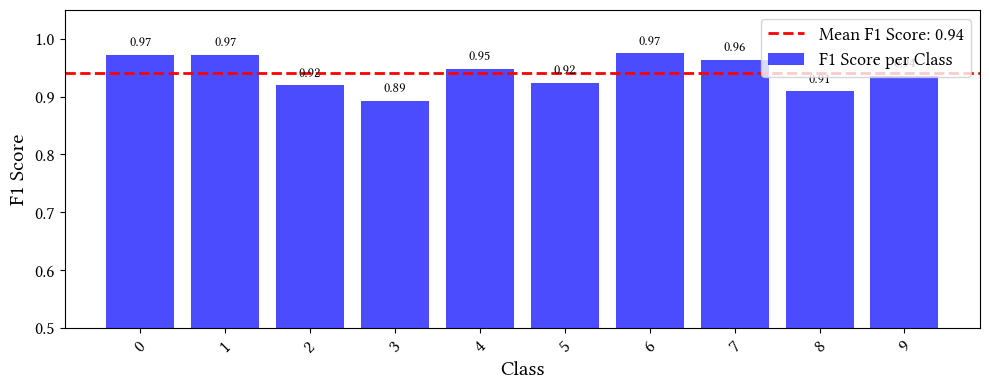

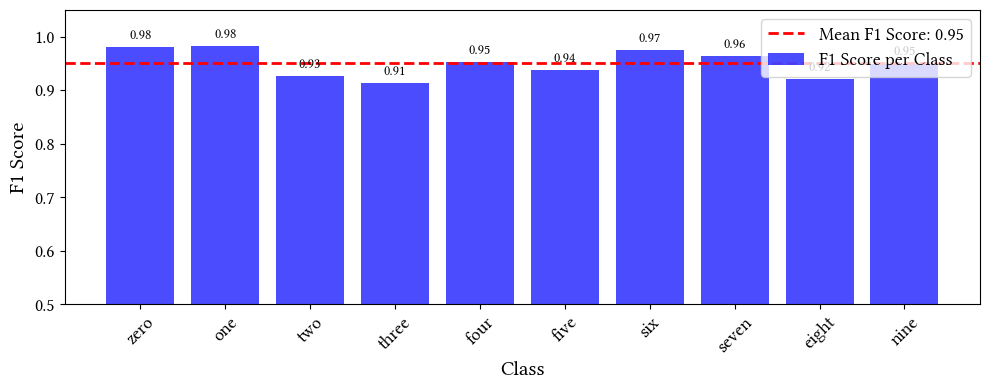

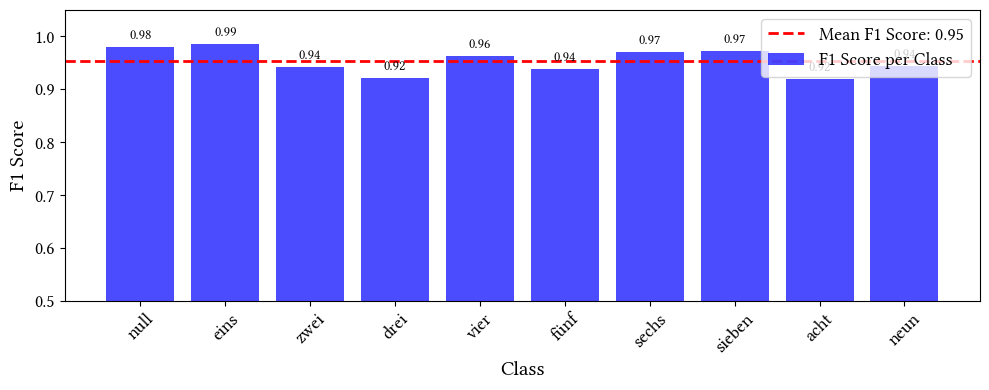

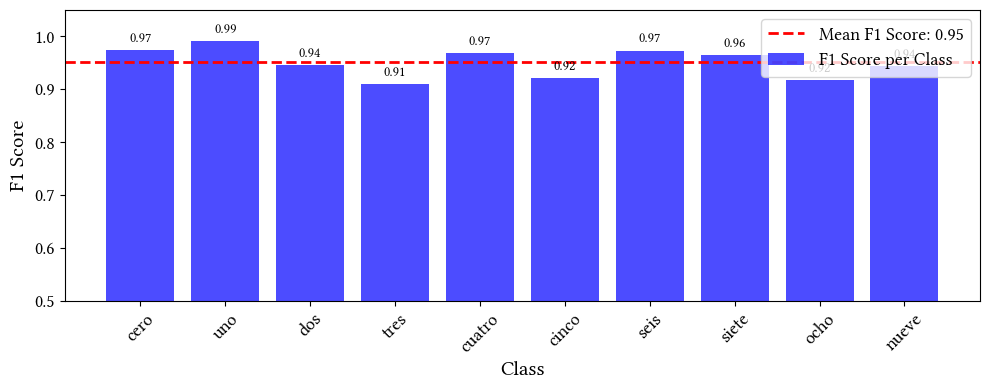

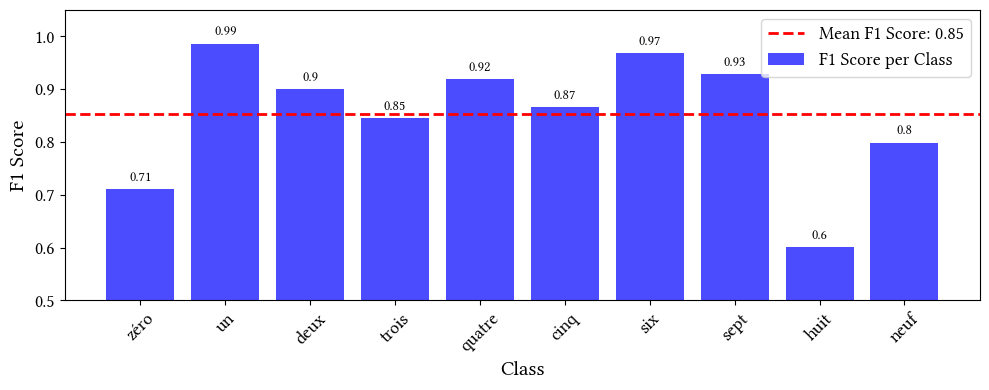

In [19]:
def plot_f1_scores_from_report(report, xticks, title='F1 Scores by Class', xlabel='Class', ylabel='F1 Score'):
    # Extracting class labels and their corresponding F1 scores
    classes = sorted([k for k in report.keys() if k.isdigit() or (isinstance(k, str) and k.replace('.', '', 1).isdigit())], key=int)
    f1_scores = [report[cls]['f1-score'] for cls in classes if cls in report]
    
    # Calculate the mean f1 score
    mean_f1 = np.mean(f1_scores)
    
    # Making the plot look more professional for a scientific paper
    plt.figure(figsize=(10, 4))
    bars = plt.bar(classes, f1_scores, color='blue', alpha=0.7, label='F1 Score per Class')
    
    # Adding the mean line without dotted style
    plt.axhline(y=mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean F1 Score: {mean_f1:.2f}')
    
    # Displaying the value of each bar (F1 score per class)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
    
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    # plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(ticks=np.arange(len(classes)), labels=xticks, rotation=45, fontsize=13)
    plt.yticks(fontsize=13)
    # plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')
    plt.legend(loc='upper right', fontsize=13)
    plt.ylim(0.5, 1.05)

    plt.tight_layout()

    plt.show()
# Assuming 'reports' is the output from the classify_and_evaluate_detailed function

language_groups = {
    'number': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
    'English': ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'],
    'German': ['null', 'eins', 'zwei', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun'],
    'Spanish': ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve'],
    'French': ['zéro', 'un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf']
}

for language, report in reports.items():
    # We're interested in plotting the 'f1-score' for each class
    plot_f1_scores_from_report(report, xticks=language_groups[language], title=f'F1 Scores by Class for {language}', xlabel='Class', ylabel='F1 Score')


# Plot image samples

In [20]:
import matplotlib.pyplot as plt

def plot_images(image_generator):
    conditions = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
        'null', 'eins', 'zwei', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun',
        'cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve',
        'zéro', 'un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf'
    ]
    images = [image_generator.generate_images(condition, 1)[0] for condition in conditions]
    display_images(images, conditions)

def display_images(images, conditions):
    """
    Display images in a grid with 10 images per row, each with a title of its condition. 
    Assumes images are in MNIST format (either (28, 28) or (1, 28, 28)).
    
    Parameters:
    - images: a list of image tensors in MNIST format
    - conditions: a list of conditions corresponding to each image
    """
    num_images = len(images)
    num_rows = (num_images + 9) // 10  # Calculate rows needed for 10 images per row
    
    # Setup figure and axes for the subplot grid
    fig, axs = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows), constrained_layout=True)
    
    for i, ax in enumerate(axs.flat):
        if i < num_images:
            # Check for channel dimension and squeeze if necessary
            image = images[i]
            if image.ndim == 3:
                image = image.squeeze(0)
            
            ax.imshow(image, cmap='gray')
            ax.set_title(f'"{conditions[i]}"', fontsize=28)
            ax.axis('off')  # Hide the axes
        else:
            ax.axis('off')  # Hide axes for empty plots
    
    plt.show()

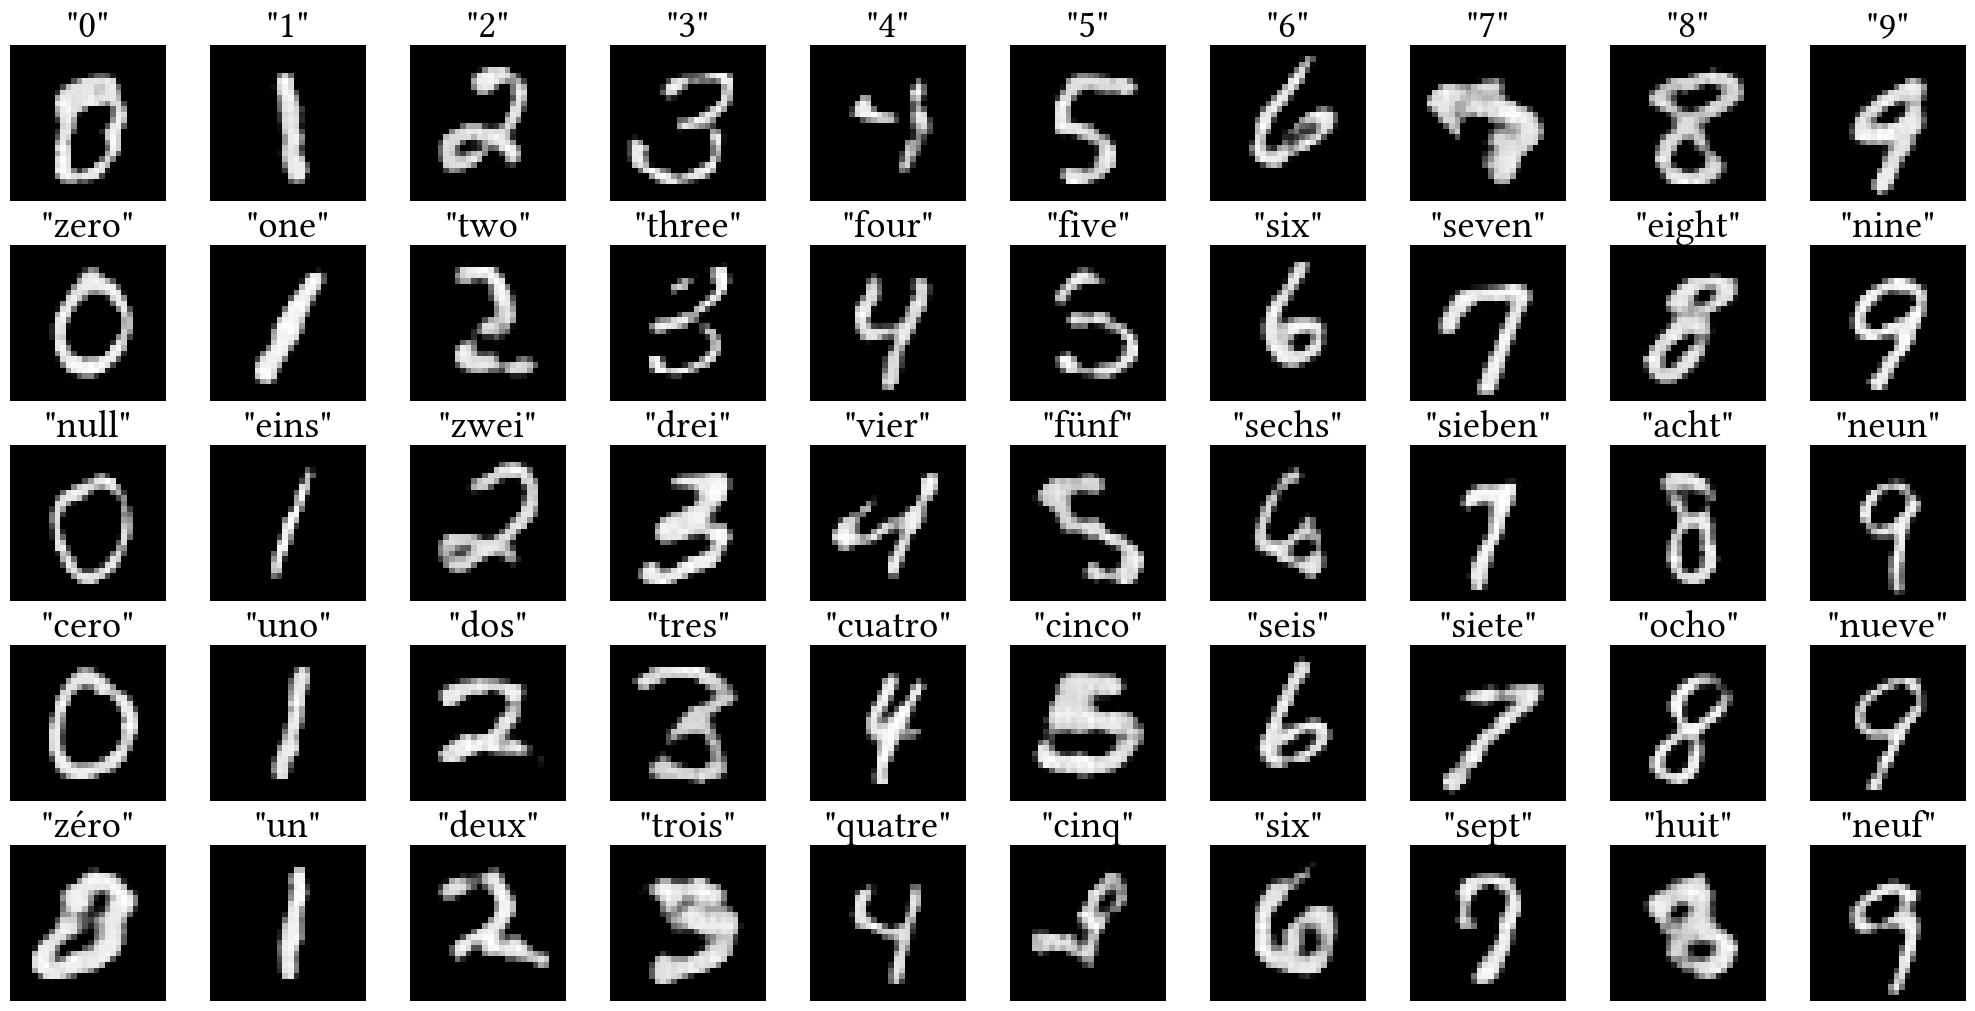

In [21]:
plot_images(image_generator)